In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

from jax.random import PRNGKey, split
import equinox as eqx
from numpyro.handlers import trace, substitute, replay

from src import GP_kernels as gpk

from tinygp import GaussianProcess, kernels
import equinox as eqx

from jax import numpy as jnp
from jax.typing import ArrayLike as JAXArray

import matplotlib.pyplot as plt




In [3]:
from typing import Callable

from tinygp.helpers import JAXArray


class CustomKernel(kernels.Kernel, eqx.Module):
  kernel_fn: Callable[[JAXArray, JAXArray], JAXArray]
  
  def evaluate(self, X1: JAXArray, X2: JAXArray) -> JAXArray:
    return self.kernel_fn(X1, X2)

In [4]:

import src.InferenceModel


model = src.InferenceModel.InferenceModel(key=PRNGKey(0), c=gpk.GPInferenceCfg(num_input_variables=(1,2),
                                                        src num_obsGPInferenceCfg100,
                                                            max_discrete_choices=4,
                                                            d_model=128,
                                                            num_enc_layers=4,
                                                            slow_compilation=False,))

model = eqx.tree_deserialise_leaves(Path("tmp/fast_gp.eqx"), model)


2023-05-05 15:44:35.277623: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
seed = PRNGKey(4457)
tr = trace(gpk.model).get_trace(key=seed)
_, original_dist = gpk.model(key = seed, return_dist=True)
obs = tr['obs']['value']
rest = {k:v['value'] for k,v in tr.items() if k!='obs'}
rest

{'kernel_type': Array(3, dtype=int32),
 'leftchild_kernel_type': Array(2, dtype=int32),
 'leftchild_leftchild_kernel_type': Array(1, dtype=int32),
 'leftchild_leftchild_lenght_scale': Array(0.15371779, dtype=float32),
 'leftchild_leftchild_scale_mixture': Array(0.5893802, dtype=float32),
 'leftchild_rightchild_kernel_type': Array(1, dtype=int32),
 'leftchild_rightchild_lenght_scale': Array(0.4958752, dtype=float32),
 'leftchild_rightchild_scale_mixture': Array(0.794331, dtype=float32),
 'rightchild_kernel_type': Array(0, dtype=int32),
 'rightchild_bias': Array(0.5424799, dtype=float32),
 'std': Array(0.08861532, dtype=float32)}

In [6]:
many_sampled_latents = []
all_dists = []
all_log_ps = []
key = PRNGKey(0)
for _ in range(100):
  key, sk = split(key)
  sampled_latents, trace_ = model.rsample(obs, gpk.model, sk)
  many_sampled_latents.append(sampled_latents)
  
  model_pred = substitute(gpk.model, sampled_latents)
  obs_, dist = model_pred(PRNGKey(5668499), return_dist=True)
  all_dists.append(dist)
  
  all_log_ps.append(dist.log_prob(obs))

/home/aldo/miniconda3/envs/tfp-jax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


In [7]:
best = jnp.array(all_log_ps).argmax()
all_log_ps[best]
sampled_latents = many_sampled_latents[best]
sampled_latents

{'kernel_type': Array(1, dtype=int32),
 'lenght_scale': Array(0.20079404, dtype=float32),
 'scale_mixture': Array(0.87806904, dtype=float32),
 'std': Array(0.12301388, dtype=float32)}

In [11]:
model_pred = substitute(gpk.model, sampled_latents)
obs_, dist = model_pred(PRNGKey(5668499), return_dist=True)
dist.log_prob(obs), dist.log_prob(obs_)

(Array(-45.56799, dtype=float32), Array(-58.59038, dtype=float32))

In [12]:
def plot_obs_and_conditioned_gp(obs, dist, std, plt_ax=None, between_name=None, y_limits=None):
  x_train = obs[:,0]
  y_train = obs[:,1]
  x_test = jnp.linspace(x_train.min(), x_train.max()+0.5*x_train.max(), 100)
  
  gp = GaussianProcess(CustomKernel(dist.kernel_fn), x_train, diag=std)
  conditioned_gp = gp.condition(y_train, x_test, diag=std).gp
  mean = conditioned_gp.mean
  std = jnp.sqrt(conditioned_gp.variance)
  
  if plt_ax is None:
    plt_ax = plt.gca()
  
  # plt_ax.scatter(x_train, y_train, label="observed")
  plt_ax.fill_between(x_test, mean-2*std, mean+2*std, alpha=0.2, label=between_name)
  # #add name to fill_between
  # if between_name is not None:
    
  
  #set y_limits
  if y_limits is not None:
    plt_ax.set_ylim(y_limits)
  
  #get y limits
  y_limits = plt_ax.get_ylim()
  
  return y_limits

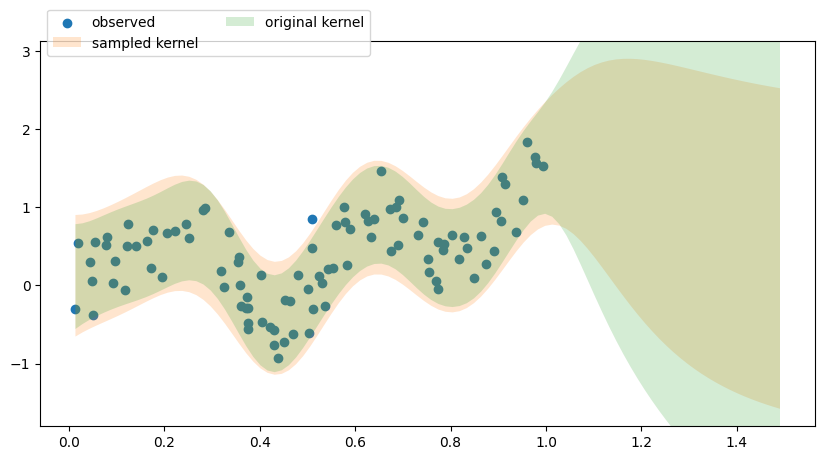

In [13]:
x_train = obs[:,0]
y_train = obs[:,1]


fig, ax =  plt.subplots(1,1, figsize=(10,5))
ax.scatter(x_train, y_train, label="observed")
y_limits = plot_obs_and_conditioned_gp(obs, dist, sampled_latents['std'], plt_ax=ax, between_name="sampled kernel")
plot_obs_and_conditioned_gp(obs, original_dist, rest['std'], plt_ax=ax, y_limits=y_limits, between_name="original kernel")
#add the labels to top left
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.1), ncol=2)
